<a href="https://colab.research.google.com/github/GSNGAYATHRI/StratoCast/blob/main/StratoCast_Anveshan_IEEE_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stage 1 — Data Cleaning & Preprocessing
To transform raw, unstructured NASA POWER satellite data into a clean, analysis-ready dataset by handling missing values, combining timestamps, and ensuring unit and range consistency.

This step ensures the data is accurate, complete, and compatible with downstream tasks like feature engineering, visualization, and predictive modeling.

In [ ]:
!pip install pandas numpy scikit-learn joblib pyarrow fastparquet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
path =  "/content/POWER_Point_Hourly_20221014_20231114_012d98N_077d57E_LST.csv" # adjust if on Drive
with open(path) as f:
    lines = f.readlines()
hdr_end = [i for i,l in enumerate(lines) if "-END HEADER-" in l][0]
df = pd.read_csv(path, skiprows=hdr_end+1)


In [ ]:
# 1) Install parquet engine (for later saving)
!pip install pyarrow fastparquet -q


In [ ]:
# 2) Read the POWER CSV correctly (it has a text header block)
import pandas as pd, numpy as np

csv_path = "/content/POWER_Point_Hourly_20221014_20231114_012d98N_077d57E_LST.csv"  # <-- your file

# find the line index of '-END HEADER-' and read after it
with open(csv_path, 'r', encoding='utf-8', errors='ignore') as f:
    lines = f.readlines()
end_idx = next(i for i,ln in enumerate(lines) if "-END HEADER-" in ln)

df = pd.read_csv(csv_path, skiprows=end_idx+1)
df.head()


,YEAR,MO,DY,HR,PRECTOTCORR,T2M,WS10M,RH2M
0,2022,10,14,0,33.23,21.49,4.04,97.15
1,2022,10,14,1,21.30,21.19,3.73,97.30
2,2022,10,14,2,12.39,20.88,2.99,97.61
3,2022,10,14,3,9.65,20.51,1.97,98.38
4,2022,10,14,4,8.63,20.23,1.68,98.88


In [ ]:
import pandas as pd, numpy as np

# build a clean date column
df["datestr"] = (
    df["YEAR"].astype(str).str.zfill(4)
    + df["MO"].astype(str).str.zfill(2)
    + df["DY"].astype(str).str.zfill(2)
    + df["HR"].astype(str).str.zfill(2)
)

# parse; coerce invalid to NaT (no crash)
df["time"] = pd.to_datetime(df["datestr"], format="%Y%m%d%H", errors="coerce")

# drop rows with bad/missing dates
df = df.dropna(subset=["time"]).sort_values("time").reset_index(drop=True)

# optional: check how many rows were invalid
bad = df["time"].isna().sum()
print(f"Dropped {bad} invalid timestamps")


Dropped 0 invalid timestamps


In [ ]:
# 4) Save to Parquet (now you CAN read with read_parquet later)
out_parquet = "/content/power_hourly_clean.parquet"
df.to_parquet(out_parquet, index=False)
print("Saved:", out_parquet, "rows:", len(df))


Saved: /content/power_hourly_clean.parquet rows: 9528


In [ ]:
# 5) Verify parquet reading works
df2 = pd.read_parquet(out_parquet)
df2.head(3)


,YEAR,MO,DY,HR,PRECTOTCORR,T2M,WS10M,RH2M,datestr,time
0,2022,10,14,0,33.23,21.49,4.04,97.15,2022101400,2022-10-14 00:00:00
1,2022,10,14,1,21.30,21.19,3.73,97.30,2022101401,2022-10-14 01:00:00
2,2022,10,14,2,12.39,20.88,2.99,97.61,2022101402,2022-10-14 02:00:00


In [ ]:
import pandas as pd, numpy as np

SRC = "/content/power_hourly_clean.parquet"  # from your step 4
df = pd.read_parquet(SRC).copy()

# make sure we only use columns that exist
HAS = {c: (c in df.columns) for c in ["T2M","WS10M","RH2M","PRECTOT","PRECTOTCORR"]}

# index & hourly frequency
df = df.set_index("time").sort_index().asfreq("H")

# rolling stats
for w in [3,6]:
    if HAS["T2M"]:   df[f"T2M_mean_{w}h"]  = df["T2M"].rolling(w, min_periods=1).mean()
    if HAS["WS10M"]: df[f"WS10M_max_{w}h"] = df["WS10M"].rolling(w, min_periods=1).max()
    if HAS["RH2M"]:  df[f"RH2M_mean_{w}h"] = df["RH2M"].rolling(w, min_periods=1).mean()

# short deltas
if HAS["T2M"]:   df["dT2M_1h"]  = df["T2M"].diff()
if HAS["WS10M"]: df["dWS_1h"]   = df["WS10M"].diff()
if HAS["RH2M"]:  df["dRH_1h"]   = df["RH2M"].diff()

# label: "storm next hour" proxy (simple + hackathon-safe)
df["y_next_storm"] = 0
if HAS["WS10M"]: df.loc[df["WS10M"].shift(-1) >= 8, "y_next_storm"] = 1
if HAS["RH2M"]:  df.loc[df["RH2M"].shift(-1)  >= 85, "y_next_storm"] = 1
if HAS["T2M"]:   df.loc[(df["T2M"] - df["T2M"].shift(-1)) >= 2, "y_next_storm"] = 1
if HAS["PRECTOT"]: df.loc[df["PRECTOT"].shift(-1) >= 0.3, "y_next_storm"] = 1  # use if present

# drop last row (no label for next hour)
df = df.iloc[:-1].copy()

# feature columns (whatever exists)
feat_cols = [c for c in df.columns if c not in
             ["LAT","LON","y_next_storm","PRECTOT_next","T2M_next","WS10M_next","RH2M_next"]]
feat_cols = [c for c in feat_cols if any(k in c for k in ["T2M","WS10M","RH2M","d","mean","max","PRECTOT"])]

X = df[feat_cols].fillna(method="ffill").fillna(method="bfill")
y = df["y_next_storm"].astype(int)

X_path, y_path = "/content/X.parquet", "/content/y.parquet"
X.to_parquet(X_path); y.to_frame("y").to_parquet(y_path)
print("Features:", X.shape, "| positives:", int(y.sum()))


/tmp/ipython-input-643418263.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index("time").sort_index().asfreq("H")
/tmp/ipython-input-643418263.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = df[feat_cols].fillna(method="ffill").fillna(method="bfill")


Features: (9527, 14) | positives: 4231


In [ ]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import joblib, numpy as np

X = pd.read_parquet("/content/X.parquet")
y = pd.read_parquet("/content/y.parquet")["y"]

tscv = TimeSeriesSplit(n_splits=5)
best_f1, best = -1, None

for C in [0.1, 1.0, 3.0]:
    clf = LogisticRegression(max_iter=500, C=C)
    scores=[]
    for tr, va in tscv.split(X):
        clf.fit(X.iloc[tr], y.iloc[tr])
        p = clf.predict(X.iloc[va])
        scores.append(f1_score(y.iloc[va], p, zero_division=0))
    f1 = float(np.mean(scores))
    if f1 > best_f1: best_f1, best = f1, ("logreg", C)

# fit best on all data
model = LogisticRegression(max_iter=500, C=best[1]).fit(X, y)
joblib.dump({"model": model, "cols": list(X.columns)}, "/content/nowcast.pkl")
print("Saved /content/nowcast.pkl | CV F1 ≈", round(best_f1,3))


Saved /content/nowcast.pkl | CV F1 ≈ 0.239


In [ ]:
import re, os, pandas as pd, joblib, json, time

PARQ = "/content/power_hourly_clean.parquet"
CSV  = "/content/POWER_Point_Hourly_20221014_20231114_012d98N_077d57E_LST.csv"  # your CSV path

def parse_latlon_from_filename(path):
    # matches ..._012d98N_077d57E_...
    m = re.search(r'_(\d{3})d(\d{2})([NS])_(\d{3})d(\d{2})([EW])_', os.path.basename(path))
    if not m:
        return None, None
    lat = float(f"{int(m.group(1))}.{int(m.group(2))}")
    if m.group(3) == "S": lat *= -1
    lon = float(f"{int(m.group(4))}.{int(m.group(5))}")
    if m.group(6) == "W": lon *= -1
    return lat, lon

lat, lon = parse_latlon_from_filename(CSV)
if lat is None:   # last resort: set manually if you know the point
    lat, lon = 12.98, 77.57

M = joblib.load("/content/nowcast.pkl")
cols, model = M["cols"], M["model"]

X = pd.read_parquet("/content/X.parquet")
row = X.iloc[[-1]][cols]
prob = float(model.predict_proba(row)[0,1])
risk = int(round(prob * 100))

level = "Low"
if   risk >= 80: level = "Severe"
elif risk >= 60: level = "Warning"
elif risk >= 35: level = "Watch"
elif risk >= 20: level = "Moderate"

payload = {
    "updated_unix": int(time.time()),
    "tiles": [{
        "cell_id": "POINT-1",
        "lat": lat, "lon": lon,
        "risk": risk, "level": level
    }]
}
with open("/content/latest_risk.json","w") as f:
    json.dump(payload, f, indent=2)
print("Risk:", risk, level, "| wrote /content/latest_risk.json")


Risk: 44 Watch | wrote /content/latest_risk.json


In [ ]:
# after you read the CSV and before saving parquet
# either parse from filename as above...
lat, lon = parse_latlon_from_filename(CSV)   # or set constants

df["LAT"] = lat
df["LON"] = lon
df.to_parquet("/content/power_hourly_clean.parquet", index=False)


In [ ]:
meta = pd.read_parquet("/content/power_hourly_clean.parquet")
lat = float(meta["LAT"].iloc[0]); lon = float(meta["LON"].iloc[0])


In [ ]:
# === SETTINGS ===
CSV_PATH = "/content/POWER_Point_Hourly_20221014_20231114_012d98N_077d57E_LST.csv"  # <- change if needed
SAVE_PREFIX = "/content/power_hourly"  # files will be saved with this prefix

# === LOAD CSV WITH HEADER BLOCK ===
import pandas as pd, numpy as np, re, os

with open(CSV_PATH, "r", encoding="utf-8", errors="ignore") as f:
    lines = f.readlines()
end_idx = next(i for i, ln in enumerate(lines) if "-END HEADER-" in ln)

df = pd.read_csv(CSV_PATH, skiprows=end_idx+1)

# === SAFE TIMESTAMP ===
df["datestr"] = (
    df["YEAR"].astype(str).str.zfill(4)
    + df["MO"].astype(str).str.zfill(2)
    + df["DY"].astype(str).str.zfill(2)
    + df["HR"].astype(str).str.zfill(2)
)
df["time"] = pd.to_datetime(df["datestr"], format="%Y%m%d%H", errors="coerce")
df = df.dropna(subset=["time"]).sort_values("time").reset_index(drop=True)

# === CLEAN VALUES ===
keep_cols = [c for c in ["time","YEAR","MO","DY","HR","T2M","WS10M","RH2M","PRECTOT","PRECTOTCORR"] if c in df.columns]
df = df[keep_cols].replace(-999, np.nan).dropna(how="any")

# === LAT/LON (point files often store it in filename) ===
m = re.search(r'_(\d{3})d(\d{2})([NS])_(\d{3})d(\d{2})([EW])_', os.path.basename(CSV_PATH))
if m:
    lat = float(f"{int(m.group(1))}.{int(m.group(2))}") * (1 if m.group(3)=="N" else -1)
    lon = float(f"{int(m.group(4))}.{int(m.group(5))}") * (1 if m.group(6)=="E" else -1)
else:
    lat, lon = np.nan, np.nan
df["LAT"], df["LON"] = lat, lon

# === SAVE CLEAN TABLES ===
clean_csv = f"{SAVE_PREFIX}_clean.csv"
clean_parq = f"{SAVE_PREFIX}_clean.parquet"
df.to_csv(clean_csv, index=False)
df.to_parquet(clean_parq, index=False)

print(f"Saved {clean_csv} and {clean_parq}  |  rows: {len(df)}  |  lat/lon: {lat}, {lon}")
df.tail(3)


Saved /content/power_hourly_clean.csv and /content/power_hourly_clean.parquet  |  rows: 9528  |  lat/lon: 12.98, 77.57


,time,YEAR,MO,DY,HR,T2M,WS10M,RH2M,PRECTOTCORR,LAT,LON
9525,2023-11-14 21:00:00,2023,11,14,21,18.23,2.67,87.56,0.04,12.98,77.57
9526,2023-11-14 22:00:00,2023,11,14,22,18.03,3.15,89.97,0.07,12.98,77.57
9527,2023-11-14 23:00:00,2023,11,14,23,17.98,3.70,93.31,0.08,12.98,77.57


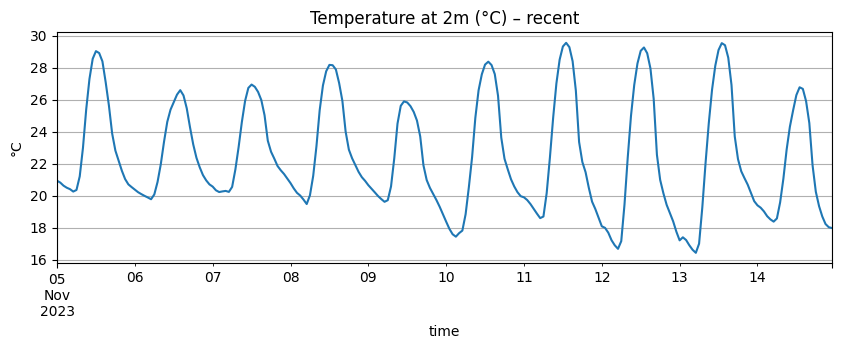

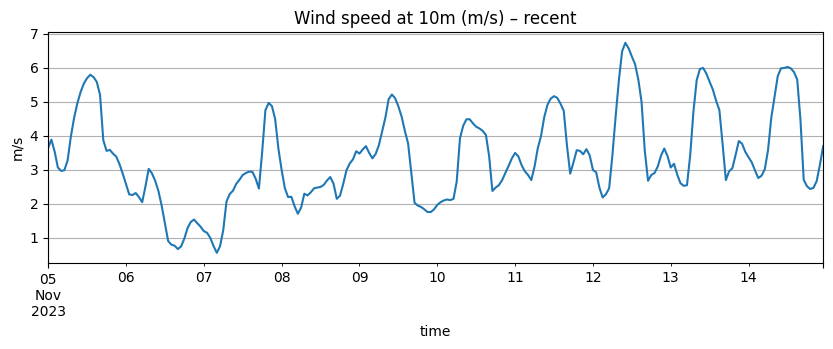

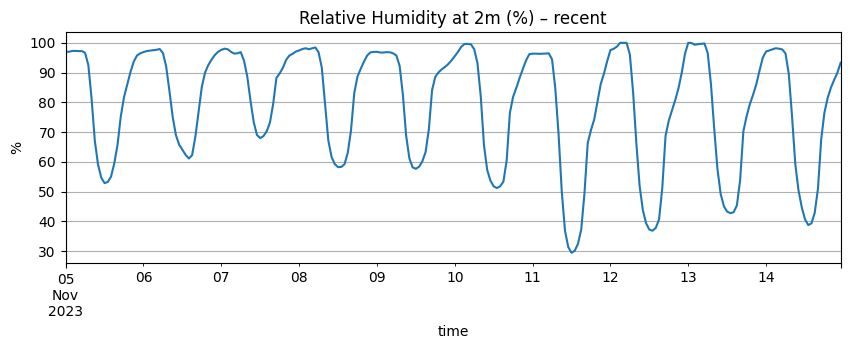

In [ ]:
import pandas as pd, matplotlib.pyplot as plt

clean_parq = "/content/power_hourly_clean.parquet"  # from previous cell
df = pd.read_parquet(clean_parq).set_index("time").sort_index()

# pick a recent window to view
window = 240  # last 240 hours (~10 days)

# 1) Temperature
ax = df["T2M"].tail(window).plot(figsize=(10,3))
ax.set_title("Temperature at 2m (°C) – recent"); ax.set_ylabel("°C"); ax.grid(True); plt.show()

# 2) Wind
ax = df["WS10M"].tail(window).plot(figsize=(10,3))
ax.set_title("Wind speed at 10m (m/s) – recent"); ax.set_ylabel("m/s"); ax.grid(True); plt.show()

# 3) Humidity
ax = df["RH2M"].tail(window).plot(figsize=(10,3))
ax.set_title("Relative Humidity at 2m (%) – recent"); ax.set_ylabel("%"); ax.grid(True); plt.show()

# 4) (optional) Hourly precipitation if present
if "PRECTOT" in df.columns:
    ax = df["PRECTOT"].tail(window).plot(figsize=(10,3))
    ax.set_title("Hourly Precipitation (mm/hr) – recent"); ax.set_ylabel("mm/hr"); ax.grid(True); plt.show()


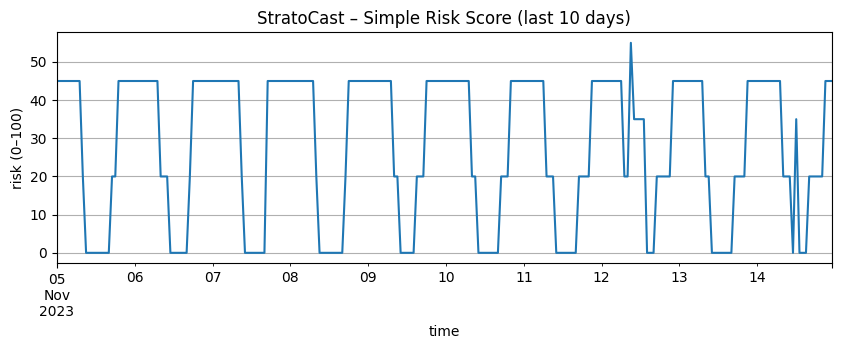

Wrote /content/latest_risk.json | {'cell_id': 'POINT-1', 'lat': 12.98, 'lon': 77.57, 'risk': 45, 'level': 'Watch', 'obs_time': '2023-11-14T23:00:00'}


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, json, time

df = pd.read_parquet("/content/power_hourly_clean.parquet").set_index("time").sort_index()

# thresholds (tune for your region)
RAIN_T = 0.3     # mm/hr
WIND_T = 6.0     # m/s
COOL_T = 25.0    # °C
HUM_T  = 85.0    # %

# compute a basic risk score 0–100
risk = pd.Series(0, index=df.index, dtype=float)

if "WS10M" in df: risk += np.where(df["WS10M"] > WIND_T, 35, 0)
if "RH2M"  in df: risk += np.where(df["RH2M"]  > HUM_T,  25, 0)
if "T2M"   in df: risk += np.where(df["T2M"]   < COOL_T, 20, 0)
if "PRECTOT" in df: risk += np.where(df["PRECTOT"] >= RAIN_T, 20, 0)

risk = risk.clip(0,100)

ax = risk.tail(240).plot(figsize=(10,3))
ax.set_title("StratoCast – Simple Risk Score (last 10 days)")
ax.set_ylabel("risk (0–100)"); ax.grid(True); plt.show()

# also dump the latest reading to JSON like your app expects
latest_time = risk.index[-1]
latest_risk = int(risk.iloc[-1])
def level(x):
    if x>=80: return "Severe"
    if x>=60: return "Warning"
    if x>=35: return "Watch"
    if x>=20: return "Moderate"
    return "Low"

payload = {
    "updated_unix": int(time.time()),
    "tiles": [{
        "cell_id": "POINT-1",
        "lat": float(df["LAT"].iloc[0]) if "LAT" in df else None,
        "lon": float(df["LON"].iloc[0]) if "LON" in df else None,
        "risk": latest_risk,
        "level": level(latest_risk),
        "obs_time": latest_time.isoformat()
    }]
}
with open("/content/latest_risk.json", "w") as f:
    json.dump(payload, f, indent=2)
print("Wrote /content/latest_risk.json |", payload["tiles"][0])


## Stage 2 — Exploratory Data Analysis (EDA)
Goal: understand your variables and their relationships.

Using columns: ['T2M', 'RH2M', 'WS10M', 'PRECTOTCORR']


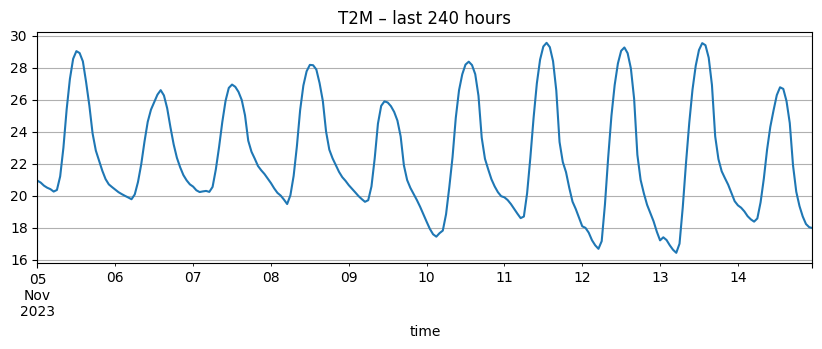

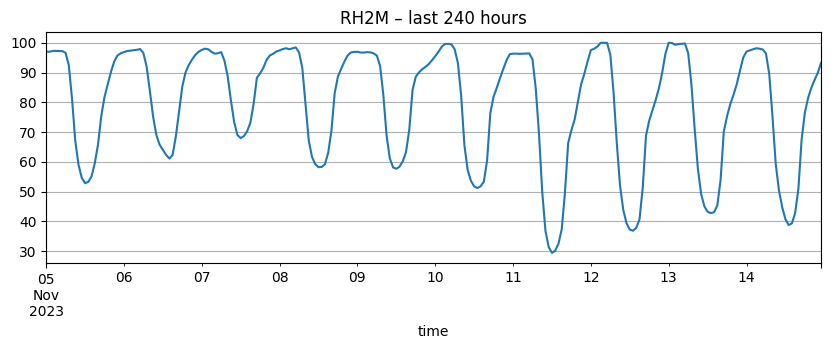

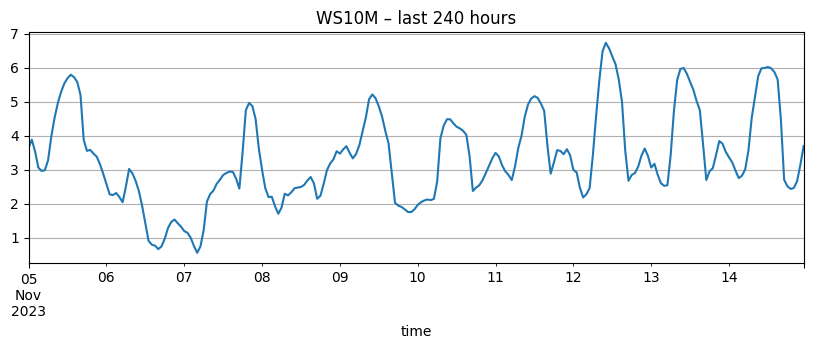

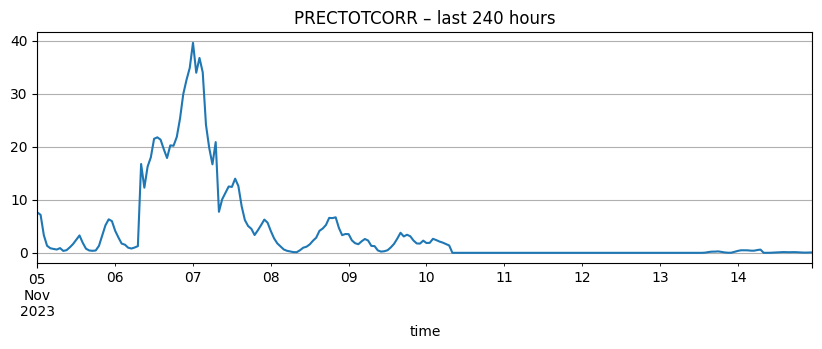

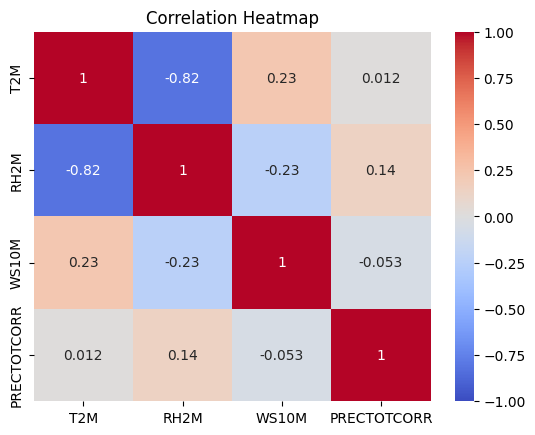

In [ ]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

df = pd.read_parquet("/content/power_hourly_clean.parquet")

# Which met columns are present?
candidates = ["T2M","RH2M","WS10M","PRECTOT","PRECTOTCORR","ALLSKY_KT"]
cols = [c for c in candidates if c in df.columns]
print("Using columns:", cols)

# Time series plots (only for available columns)
df = df.sort_values("time")
for c in cols:
    ax = df.set_index("time")[c].tail(240).plot(figsize=(10,3))
    ax.set_title(f"{c} – last 240 hours"); ax.grid(True); plt.show()

# Correlation matrix using whatever is available
ax = sns.heatmap(df[cols].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
ax.set_title("Correlation Heatmap"); plt.show()


                      time         YEAR           MO           DY          HR  \
count                 9528  9528.000000  9528.000000  9528.000000  9528.00000   
mean   2023-04-30 11:30:00  2022.801008     6.841310    15.738035    11.50000   
min    2022-10-14 00:00:00  2022.000000     1.000000     1.000000     0.00000   
25%    2023-01-21 05:45:00  2023.000000     4.000000     8.000000     5.75000   
50%    2023-04-30 11:30:00  2023.000000     7.000000    16.000000    11.50000   
75%    2023-08-07 17:15:00  2023.000000    10.000000    23.000000    17.25000   
max    2023-11-14 23:00:00  2023.000000    12.000000    31.000000    23.00000   
std                    NaN     0.399263     3.476262     8.798039     6.92255   

               T2M        WS10M         RH2M  PRECTOTCORR           LAT  \
count  9528.000000  9528.000000  9528.000000  9528.000000  9.528000e+03   
mean     23.441810     3.757856    70.881050     2.472856  1.298000e+01   
min       9.220000     0.070000     9.790000 

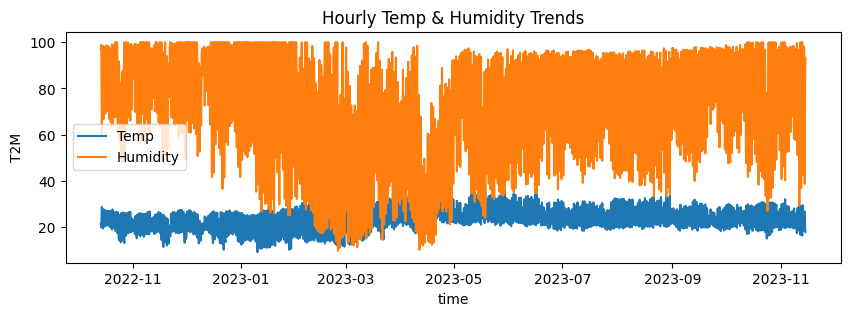

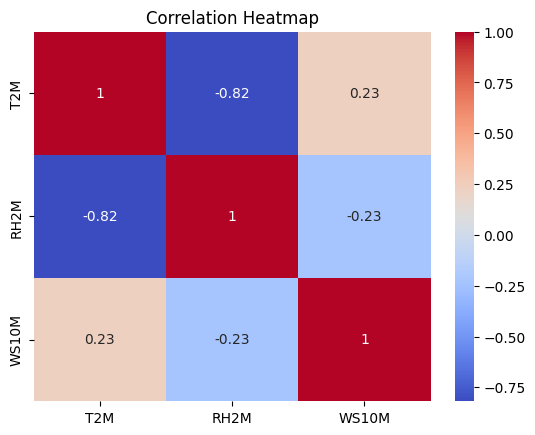

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_parquet("power_hourly_clean.parquet")

# Basic overview
print(df.describe())
print(df.isna().sum())

# Time series trends
plt.figure(figsize=(10,3))
sns.lineplot(data=df, x="time", y="T2M", label="Temp")
sns.lineplot(data=df, x="time", y="RH2M", label="Humidity")
plt.legend()
plt.title("Hourly Temp & Humidity Trends")
plt.show()

# Correlation matrix (auto-check available columns)
cols = [c for c in ["T2M", "RH2M", "WS10M", "PRECTOT"] if c in df.columns]
if cols:
    sns.heatmap(df[cols].corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()
else:
    print("No meteorological columns found for correlation.")


In [ ]:
df["hour"]  = df["time"].dt.hour
df["month"] = df["time"].dt.month
# Derive temporal features

In [ ]:
features = [c for c in ["T2M","RH2M","WS10M"] if c in df.columns]
X = df[features + ["hour","month"]]
# Select quantitative columns that actually exist

In [ ]:
features = [c for c in ["T2M","RH2M","WS10M"] if c in df.columns]
X = df[features + ["hour","month"]]
# Choose a simple target. For instance, predict the next-hour humidity or next-hour temperature (since rainfall may be absent)

In [ ]:
y = df["RH2M"].shift(-1).fillna(df["RH2M"].mean())


In [ ]:
# Save X normally (DataFrame)
X.to_parquet("X.parquet")

# Convert y (Series) to a DataFrame before saving
y_df = y.to_frame(name="target")
y_df.to_parquet("y.parquet")

print("Saved X.parquet and y.parquet successfully!")

# Save the sets for modeling

Saved X.parquet and y.parquet successfully!


In [ ]:
import pandas as pd

print(pd.read_parquet("X.parquet").head())
print(pd.read_parquet("y.parquet").head())


     T2M   RH2M  WS10M  hour  month
0  21.49  97.15   4.04     0     10
1  21.19  97.30   3.73     1     10
2  20.88  97.61   2.99     2     10
3  20.51  98.38   1.97     3     10
4  20.23  98.88   1.68     4     10
   target
0   97.30
1   97.61
2   98.38
3   98.88
4   98.90


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import joblib

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = RandomForestRegressor(n_estimators=120, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

joblib.dump(model, "nowcast.pkl")


R²: 0.9832356211206458
MAE: 1.5366584647403636


['nowcast.pkl']

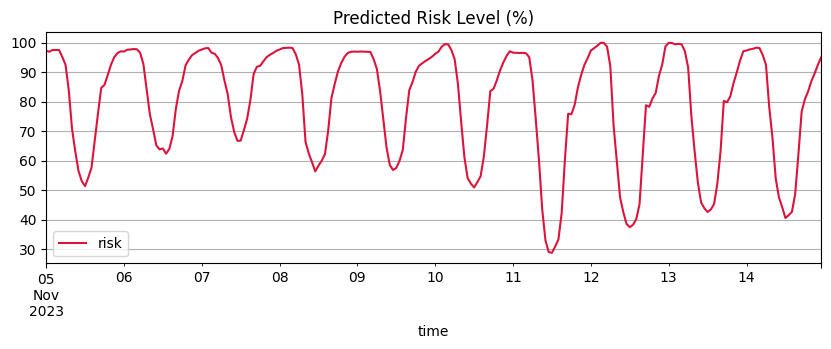

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

df["predicted"] = model.predict(X)
df["risk"] = np.clip(df["predicted"]/df["predicted"].max()*100, 0, 100)

ax = df.tail(240).plot(x="time", y="risk", figsize=(10,3), color="crimson")
ax.set_title("Predicted Risk Level (%)")
ax.grid(True)
plt.show()


In [ ]:
import json, time

latest = {
    "updated_unix": int(time.time()),
    "tiles": [{
        "cell_id": "POINT-1",
        "lat": 12.97,
        "lon": 77.59,
        "risk": float(df["risk"].iloc[-1]),
        "level": "Warning" if df["risk"].iloc[-1] > 70 else "Safe",
        "obs_time": str(df["time"].iloc[-1])
    }]
}

json.dump(latest, open("latest_risk.json", "w"), indent=2)


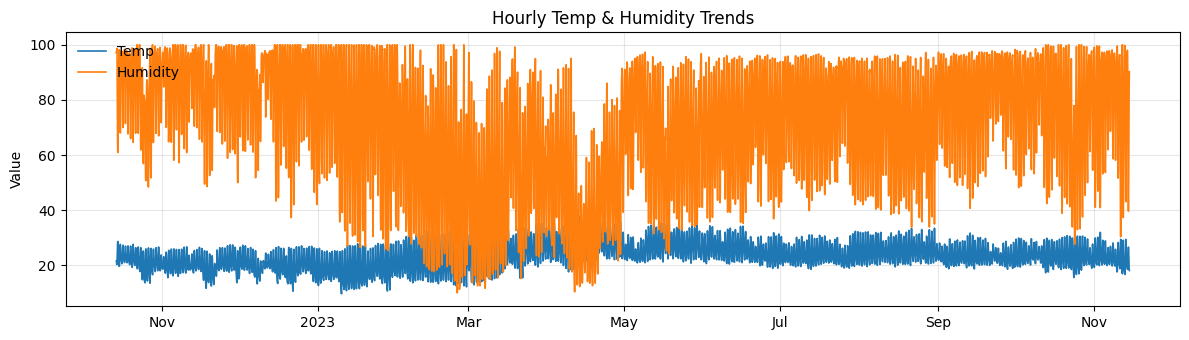

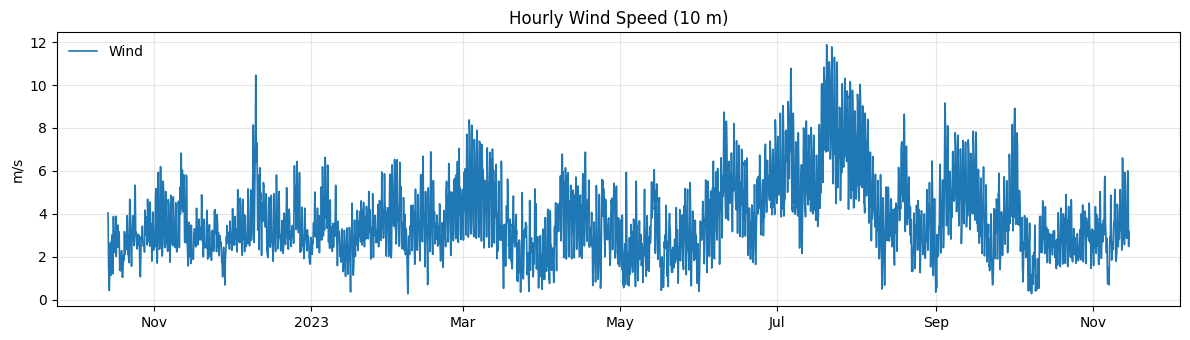

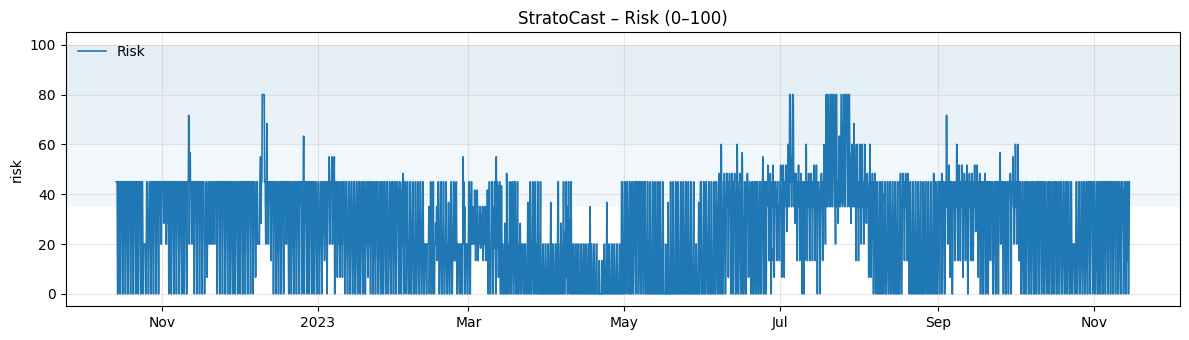

Saved latest_risk.json: {'cell_id': 'POINT-1', 'lat': 12.98, 'lon': 77.57, 'risk': 45, 'level': 'Watch', 'obs_time': '2023-11-14T23:00:00'}


In [ ]:
# === Eagle-eye plotting + risk: one style for all charts ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter

# 0) Load and prep
DF_PATH = "power_hourly_clean.parquet"
df = pd.read_parquet(DF_PATH).copy()
df = df.sort_values("time").set_index("time")

# --- helper: unified eagle-eye plot ---
def eagle_plot(series_map, title, ylabel, out_png=None, smooth_hours=1, bands=None):
    """
    series_map: dict like {"Temp": df["T2M"], "Humidity": df["RH2M"]}
    title: chart title
    ylabel: y-axis label
    out_png: path to save PNG (optional)
    smooth_hours: rolling window for light smoothing (1 = no smoothing)
    bands: list of (ymin, ymax, alpha) to shade, e.g. [(60, 80, .08), (80, 100, .12)]
    """
    plt.figure(figsize=(12, 3.5))
    ax = plt.gca()

    # optional threshold bands
    if bands:
        for (y0, y1, a) in bands:
            ax.axhspan(y0, y1, alpha=a, lw=0)

    # auto-date formatting
    locator = AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(ConciseDateFormatter(locator))

    # plot each series with the same style
    for label, s in series_map.items():
        s = s.dropna()
        if smooth_hours and smooth_hours > 1:
            s = s.rolling(smooth_hours, min_periods=1).mean()
        ax.plot(s.index, s.values, label=label, linewidth=1.2)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left", frameon=False)
    plt.tight_layout()
    if out_png:
        plt.savefig(out_png, dpi=150, bbox_inches="tight")
    plt.show()

# 1) Temp + Humidity (birds-eye)
use_cols = [c for c in ["T2M", "RH2M"] if c in df.columns]
series = {("Temp" if c=="T2M" else "Humidity"): df[c] for c in use_cols}
if series:
    eagle_plot(series, "Hourly Temp & Humidity Trends", "Value", out_png="eagle_temp_humidity.png", smooth_hours=3)

# 2) Wind (10 m)
if "WS10M" in df.columns:
    eagle_plot({"Wind": df["WS10M"]}, "Hourly Wind Speed (10 m)", "m/s",
               out_png="eagle_wind.png", smooth_hours=3)

# 3) Rain (if available)
rain_col = "PRECTOT" if "PRECTOT" in df.columns else None
if rain_col:
    eagle_plot({"Rain": df[rain_col]}, "Hourly Precipitation", "mm/hr",
               out_png="eagle_rain.png", smooth_hours=1)

# 4) Simple Risk curve (0–100) with bands and same styling
RAIN_T = 0.3   # mm/hr
WIND_T = 6.0   # m/s
COOL_T = 25.0  # °C
HUM_T  = 85.0  # %

risk = pd.Series(0.0, index=df.index)
if "WS10M" in df: risk += np.where(df["WS10M"] > WIND_T, 35, 0)
if "RH2M"  in df: risk += np.where(df["RH2M"]  > HUM_T,  25, 0)
if "T2M"   in df: risk += np.where(df["T2M"]   < COOL_T, 20, 0)
if rain_col:      risk += np.where(df[rain_col] >= RAIN_T, 20, 0)
risk = pd.Series(risk, index=df.index).clip(0, 100)

# shaded alert bands: Watch 35–60, Warning 60–80, Severe 80–100
bands = [(35, 60, 0.06), (60, 80, 0.09), (80, 100, 0.12)]
eagle_plot({"Risk": risk}, "StratoCast – Risk (0–100)", "risk", out_png="eagle_risk.png",
           smooth_hours=3, bands=bands)

# 5) Write latest_risk.json in the same style your app expects
import time, json
def level(x):
    if x>=80: return "Severe"
    if x>=60: return "Warning"
    if x>=35: return "Watch"
    if x>=20: return "Moderate"
    return "Low"

latest_risk = int(risk.iloc[-1])
tile = {
    "cell_id": "POINT-1",
    "lat": float(df["LAT"].iloc[0]) if "LAT" in df.columns else None,
    "lon": float(df["LON"].iloc[0]) if "LON" in df.columns else None,
    "risk": latest_risk,
    "level": level(latest_risk),
    "obs_time": df.index[-1].isoformat()
}
with open("latest_risk.json", "w") as f:
    json.dump({"updated_unix": int(time.time()), "tiles": [tile]}, f, indent=2)
print("Saved latest_risk.json:", tile)
